In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer, TargetEncoder, OneHotEncoder, StandardScaler, QuantileTransformer
from dateutil.parser import parse
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('./movie_dataset.csv', index_col=0)

In [4]:
# Нормализация целевой переменной
cols = ['runtime', 'budget', 'revenue']
scalers = {}
for col in cols:
    scaler = StandardScaler()
    # scaler = QuantileTransformer(output_distribution='normal', random_state=0)
    df[col] = scaler.fit_transform(df[[col]])
    scalers[col] = scaler

In [5]:
# Обрабатываем NaN
df['budget'] = df['budget'].replace({0: np.NAN})
df.dropna(subset=['budget', 'mpaa', 'director', 'genres', 'domestic_distributor', 'production_companies', 'production_countries', 'spoken_languages'], inplace=True)

# Удаляем ненужные поля
df = df.drop(columns=['status'], axis=1)

# Приводим строки в датафрейме к Python-объектам
literal_eval_cols = ['genres', 'production_countries', 'production_companies', 'actors', 'spoken_languages']

for col in literal_eval_cols:
    df[col] = df.apply(lambda x: literal_eval(x[col]), axis=1)

# One hot encoding для возрастного рейтинга
one_hot_enc = OneHotEncoder(sparse_output=False)

mpaa_encoded = one_hot_enc.fit_transform(df[['mpaa']])
classes = [('mpaa_' + x.upper()) for x in one_hot_enc.categories_[0]]
df = df.join(pd.DataFrame(mpaa_encoded.astype(bool), df.index, classes))

df = df.drop(columns=['mpaa'], axis=1)

# Many Hot Encoding для жанров
mlb = MultiLabelBinarizer()
dum = mlb.fit_transform(df['genres'])
classes = ['genre_' + x.replace(' ', '_').lower() for x in mlb.classes_]
df = df.join(pd.DataFrame(dum.astype(bool), df.index, classes))

genres = set(mlb.classes_)
print('Количество жанров:', len(genres))
print('Жанры: ', genres)

df = df.drop(columns=['genres'], axis=1)

# Актеры
df = df.join(pd.DataFrame(df['actors'].values.tolist(), df.index, ['actor_1', 'actor_2', 'actor_3']))
df = df.drop(['actors'], axis=1)

df = df[df['actor_1'].notna()]
df = df[df['actor_2'].notna()]
df = df[df['actor_3'].notna()]

# Дата выхода
y = df.apply(lambda x: parse(x['release_date']).year, axis=1)
m = df.apply(lambda x: parse(x['release_date']).month, axis=1)
d = df.apply(lambda x: parse(x['release_date']).day, axis=1)

df = df.join(y.rename('release_year'))
df = df.join(m.rename('release_month'))
df = df.join(d.rename('release_day'))

one_hot_enc = OneHotEncoder(sparse_output=False)

mpaa_encoded = one_hot_enc.fit_transform(df[['release_month']])
classes = [f'release_month_{x}' for x in one_hot_enc.categories_[0]]
df = df.join(pd.DataFrame(mpaa_encoded.astype(bool), df.index, classes))

df = df.drop(columns=['release_date'], axis=1)

# Для полей, которые в качестве значений имеют массивы, выбираем только 1-ое значение
df['production_companies'] = df.apply(lambda row: row['production_companies'][0], axis=1)
df['production_countries'] = df.apply(lambda row: row['production_countries'][0], axis=1)
df['spoken_languages'] = df.apply(lambda row: row['spoken_languages'][0], axis=1)

def target_encoding_col(col):
    y = df['revenue'].values
    X = df[col]
    X = X.values.reshape(-1, 1)

    enc_auto = TargetEncoder(target_type='continuous', smooth="auto")
    return enc_auto.fit_transform(X, y)

target_encoded_columns = [
    'production_companies',
    'production_countries',
    'spoken_languages',
    'actor_1',
    'actor_2',
    'actor_3',
    'director',
    'original_language',
    'domestic_distributor',
]

for col in target_encoded_columns:
    df[col] = target_encoding_col(col)


df = df.drop(columns=['id', 'imdb_id', 'tagline', 'overview', 'vote_average', 'vote_count', 'domestic_opening', 'original_title', 'title'])

Количество жанров: 20
Жанры:  {'Family', 'Thriller', 'Documentary', 'Romance', 'History', 'Adventure', 'Action', 'War', 'Western', 'TV Movie', 'Fantasy', 'Crime', 'Comedy', 'Music', 'Horror', 'Science Fiction', 'Animation', 'Foreign', 'Mystery', 'Drama'}


In [6]:
df.shape

(6922, 58)

In [7]:
df.dtypes

original_language        float64
production_companies     float64
production_countries     float64
runtime                  float64
spoken_languages         float64
domestic_distributor     float64
budget                   float64
revenue                  float64
director                 float64
mpaa_APPROVED               bool
mpaa_G                      bool
mpaa_GP                     bool
mpaa_M                      bool
mpaa_M/PG                   bool
mpaa_NC-17                  bool
mpaa_NOT RATED              bool
mpaa_PG                     bool
mpaa_PG-13                  bool
mpaa_R                      bool
mpaa_UNRATED                bool
genre_action                bool
genre_adventure             bool
genre_animation             bool
genre_comedy                bool
genre_crime                 bool
genre_documentary           bool
genre_drama                 bool
genre_family                bool
genre_fantasy               bool
genre_foreign               bool
genre_hist

In [8]:
y = df['revenue']
df = df.drop(['revenue'], axis=1)
X = df.values.astype(float)

In [9]:
from sklearn.model_selection import train_test_split

# Разбиваем исходный датасет: 90% - тренировочный, 5% - валидационный, 5% - тестовый
# Для того, чтобы в каждом датасете были все классы, указываем аргумент stratify
X_train, X_dum, y_train, y_dum = train_test_split(X, y, test_size=0.1)
X_val, X_test, y_val, y_test = train_test_split(X_dum, y_dum ,test_size=0.5)

In [10]:
from keras import layers
from keras.models import Model

def build_regression_model(input_shape):
    input = layers.Input(shape=input_shape)
    hidden = layers.Dense(32, activation='relu')(input)
    hidden = layers.Dense(64, activation='relu')(hidden)
    hidden = layers.Dense(128, activation='relu')(hidden)
    hidden = layers.Dense(64, activation='relu')(hidden)
    hidden = layers.Dense(32, activation='relu')(hidden)
    output = layers.Dense(1)(hidden)

    model = Model(inputs=input, outputs=output) # To define a model, just specify its input and output layers

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
df.isnull().any().any()

False

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import load_model

m = build_regression_model(df.shape[1])

# Настриваем сохранение лучшей модели
checkpoint_path = "./best-model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_mae', save_best_only=True, mode='min', verbose=1)
# Настраиваем callback для ранней остановки модели
early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.1, patience=5, verbose=1)
# Настраиваем callback для TensorBoard
tensorboard = TensorBoard(log_dir="./logs")

# Обучение модели
full_history = m.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[
        checkpoint,
        early_stopping,
        tensorboard,
    ],
)

Epoch 1/50
382/390 [============================>.] - ETA: 0s - loss: 10.2446 - mae: 1.6090
Epoch 1: val_mae improved from inf to 0.80982, saving model to ./best-model.keras
390/390 [==============================] - 3s 3ms/step - loss: 10.1004 - mae: 1.6009 - val_loss: 3.6058 - val_mae: 0.8098
Epoch 2/50
380/390 [============================>.] - ETA: 0s - loss: 2.6972 - mae: 1.0277
Epoch 2: val_mae did not improve from 0.80982
390/390 [==============================] - 1s 4ms/step - loss: 2.6637 - mae: 1.0198 - val_loss: 2.6113 - val_mae: 1.0210
Epoch 3/50
379/390 [============================>.] - ETA: 0s - loss: 2.4129 - mae: 1.0251
Epoch 3: val_mae improved from 0.80982 to 0.63070, saving model to ./best-model.keras
390/390 [==============================] - 1s 4ms/step - loss: 2.4132 - mae: 1.0308 - val_loss: 1.8855 - val_mae: 0.6307
Epoch 4/50
390/390 [==============================] - ETA: 0s - loss: 1.6857 - mae: 0.8289
Epoch 4: val_mae improved from 0.63070 to 0.59027, saving

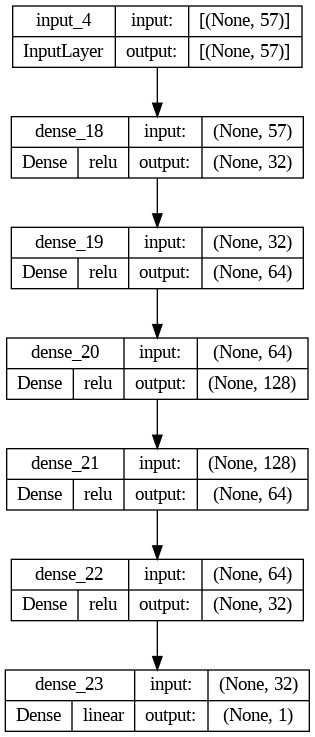

In [ ]:
from keras.utils import plot_model

plot_model(m, show_shapes=True, show_layer_activations=True)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Функция для оценки полученной модели
def inspect_regression_model(model):
  results = model.evaluate(X_test, y_test, batch_size=128)
  print('test loss:', results[0])
  print('test MAE:', results[1])
  print('test MAE (inversed):', scalers['revenue'].inverse_transform(np.array(results[1]).reshape(-1, 1)))

# Загрузка лучшей модели
best_model = load_model(checkpoint_path)
# Проверка лучшей модели
inspect_regression_model(best_model)

3/3 [==============================] - 0s 6ms/step - loss: 0.8592 - mae: 0.4898
test loss: 0.8592227697372437
test MAE: 0.4898073375225067
test MAE (inversed): [[75335798.35869034]]


In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
